

## Analisis A/B Testing untuk Meningkatkan Pendapatan Situs Web <br>

### Pendahuluan
- <b>Background </b>: <br><br> Analisis A/B Testing untuk Meningkatkan Pendapatan Situs Web
Proyek ini berfokus pada analisis hasil A/B testing yang dilakukan oleh situs web untuk meningkatkan pendapatannya. Data yang digunakan dalam proyek ini diperoleh dari sumber Kaggle dan berisi informasi tentang hasil eksperimen, jenis sampel yang digunakan (variant_name), dan pendapatan yang dihasilkan oleh pengguna (revenue).<br><br>
- <b>Objective</b> :<br><br>
Tujuan utama dari proyek ini adalah menganalisis hasil dari eksperimen A/B yang telah dilakukan oleh situs web dan memberikan rekomendasi berdasarkan analisis tersebut. Kami akan mengidentifikasi apakah perubahan yang diuji pada tata letak situs web (varian A dan B) memiliki dampak signifikan terhadap pendapatan. Dengan demikian, rekomendasi akan diberikan untuk memandu keputusan lebih lanjut terkait perubahan tersebut.
<br><br>
- <b>Bussines Question</b> : <br><br>
    - Variant mana yang dapat meningkatkan pendapatan (revenue) selama a/b testing?
    - Apakah terdapat perbedaan pendapatan (revenue) antara tiap variant secara signifikan?
    - Apa informasi yang dapat diberikan setelah a/b testing dilakukan? <br><br>

- <b>Aprroach</b>:<br><br>
Untuk menjawab pertanyaan ini, beberapa pendekatan statistik dilakukan seperti uji normalitas dan uji homogenitas untuk mengetahui karakteristik variabel revenue. Lalu dilanjutkan uji t maupun uji Mann-Whitney U pada rata-rata revenue tiap variant agar mengetahui apakah ada perbedaan rata-rata tiap variant. Dengan menjawab pertanyaan, diharapkan kedepannya informasi yang diberikan dapat membantu <i>stakeholders</i> untuk membuat keputusan dan pada akhirnya bisa meningkatkan pendapatan bisnis.

### Data Understanding
<br>Data understanding dilakukan untuk mengenali data secara keseluruhan. Beberapa langkah yang dilakukan sebagai berikut:<br><br>
a. Penjelasan tiap variabel<br>
Penjelasan variabel meliputi pengertian dari semua variabel yang ada.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('AB_Test_Results.csv')
data.head()

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


- USER_ID : Nomer unique dari tiap individu saat dilakukannya observasi (integer)<br>
- VARIANT_NAME : Variant treatment yang dilakukan terhadap objek (string)<br>
- REVENUE : Harga yang dikeluarkan user untuk membeli produk atau jasa (float) <br>

b. Mengecek nilai null pada tiap variabel<br>
Pengecekan nilai null ini dilakukan untuk mendeteksi apakah terdapat nilai null didalam data.

In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


Ternyata untuk tiap variabel tidak memiliki data null.<br> <br>
b. Mengecek duplikasi data

In [3]:
variant = data.loc[data['VARIANT_NAME'] == 'variant']
control = data.loc[data['VARIANT_NAME'] == 'control']

variant.duplicated(subset='USER_ID').sum(), control.duplicated(subset='USER_ID').sum()

(1082, 1053)

Di sini terindikasi adanya duplikasi data pada observasi tiap variant name. Maka dari itu, kita harus menghapusnya

In [4]:
new_variant = variant.drop_duplicates(subset=['USER_ID'], keep='first').reset_index(drop=True)
new_control = control.drop_duplicates(subset=['USER_ID'], keep='first').reset_index(drop=True)

new_variant.shape, new_control.shape

((3934, 3), (3931, 3))

Data yang terindikasi sudah terhapus, dan langsung saja kita gabungkan seperti semula.

In [5]:
data = pd.concat([new_control, new_variant], axis=0).reset_index(drop=True)
data

,USER_ID,VARIANT_NAME,REVENUE
0,2423,control,0.0
1,9411,control,0.0
2,7311,control,0.0
3,2849,control,0.0
4,9168,control,0.0
...,...,...,...
7860,2259,variant,0.0
7861,4883,variant,0.0
7862,8864,variant,0.0
7863,9303,variant,0.0


### Exploratory Data Analysis

<br> Exploratory data analysis ini dilakukan untuk mengetahui karateristik data secara visual dan juga tanpa harus mengecek tiap data secara terpisah. Beberapa langkah yang dilakukan sebegai berikut:<br><br>
a. Univariat 

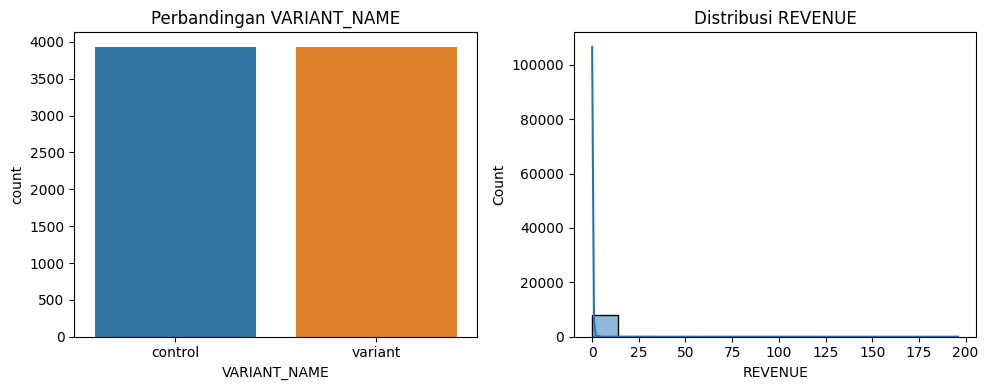

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))

ax1 = sns.countplot(data=data, x='VARIANT_NAME', ax=ax[0])
ax1.set_title('Perbandingan VARIANT_NAME')
ax2 = sns.histplot(data=data, x='REVENUE', kde=True ,ax=ax[1])
ax2.set_title('Distribusi REVENUE')

plt.tight_layout()
plt.show()

Untuk gambar yang kiri (bar graph), kita bisa mendapat informasi bahwa banyaknya jumlah observasi pada tipe variant dan control itu hampir sama banyak. Lanjut untuk gambar kanan (histogram plot), tentu kita kesulitan untuk memahami data karena pada awalnya, tujuan kita membuat histogram plot ini yaitu untuk mengetahui distribusi variabel REVENUE, apakah berdistribusi normal atau tidak. <br><br>
b. Bivariat

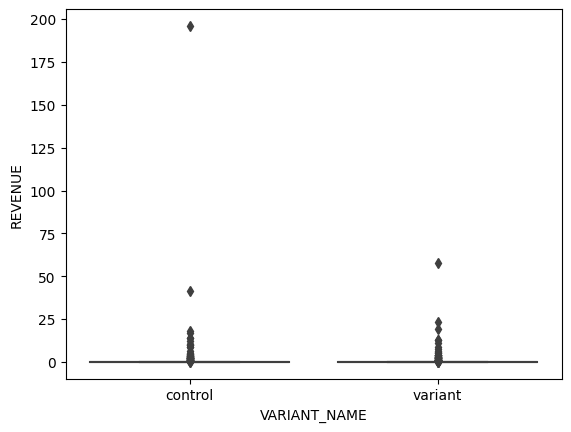

In [7]:
sns.boxplot(data=data, x='VARIANT_NAME', y='REVENUE')
plt.show()

Pada gambar plot ini, kita mendapati bahwa ada nilai ekstrim(outlier) pada VARIANT_NAME, maka dari itu kita harus menghapusnya agar nilai rata-rata VARIANT_NAME tidak terganggu olehnya. langkah awal, kita harus mencari index dari nilai ekstrim itu dengan cara mengurut nilai REVENUE secara menurun, lalu kita seleksi USER_ID yang memiliki nilai ekstrim tersebut.

In [8]:
data.sort_values(by='REVENUE', ascending=False).head(3)

,USER_ID,VARIANT_NAME,REVENUE
684,3342,control,196.01
7113,7206,variant,57.46
3744,6792,control,41.53


Kita mendapati USER_ID memiliki nilai yang ekstrim yaitu USER_ID 3342.

In [9]:
data = data.loc[data['USER_ID'] != 3342].reset_index(drop=True)
data.sort_values(by='REVENUE', ascending=False).head(3)

,USER_ID,VARIANT_NAME,REVENUE
7112,7206,variant,57.46
3743,6792,control,41.53
5109,7356,variant,23.04


Sudah terlihat di sini tidak ada nilai ekstrim yang tersimpan di dalam data.

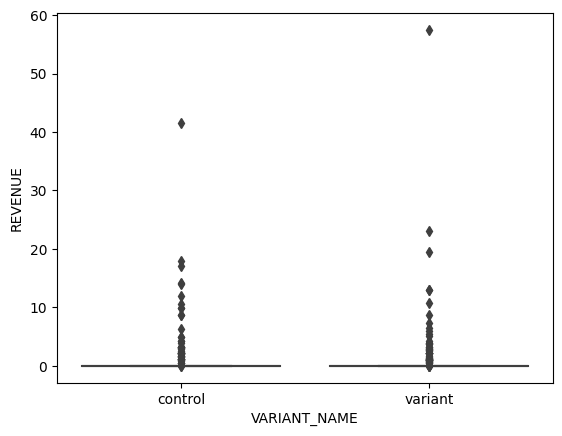

In [10]:
sns.boxplot(data=data, x='VARIANT_NAME', y='REVENUE')
plt.show()

### Uji hipotesis
Pada subbab ini, kita akan membuat hipotesis untuk membuktikan apakah ada perbedaan rata-rata yang signifikan antara VARIANT_NAME control dan VARIANT_NAME variant. Untuk itu, lihat dulu rata-rata tiap variant.

In [11]:
data.groupby(['VARIANT_NAME']).agg({'REVENUE' : 'mean'})

,REVENUE
VARIANT_NAME,
control,0.065232
variant,0.064830


Meskipun rata-rata REVENUE dari control terlihat lebih baik. Namun pada poin ini, kita tidak tahu apakah perbedaan angka ini hanya dari kebetulan yang acak. Maka dari itu, kita membangun hipotesis seperti berikut:<br>
- h0 : Tidak ada perbedaan yang signifikan antara rata-rata control dengan rata-rata variant 
- h1 : Ada perbedaan yang signifikan antara rata-rata control dengan rata-rata variant 



<br> Pada tahap ini, kita akan melakukan a/b testing. Langkah awal yang dilalukan yaitu melakukan uji normalitas dan uji homogenitas pada data yang ada. Hal ini dilakukan untuk mengetahui karakteristik data dan juga sebagai syarat untuk uji selanjutnya. Metode parametrik disyaratkan data mengikuti distribusi normal dan juga bersifat homogen. Jika metode parametrik ini tidak bisa digunakan, maka ada alternatif lain yaitu menggunakan metode non-parametrik.
<br><br> Langkah awal yang harus digunakan yaitu uji normalitas menggunakan uji shapiro-wilk. Sebelum itu, kita harus menuliskan hipotesis untuk uji shapiro-wilk :<br>
- h0 : Data mengikuti distribusi normal
- h1 : Data tidak mengikuti distribusi normal


In [12]:
from scipy.stats import shapiro

statistic_control, pvalue_control = shapiro(data[data['VARIANT_NAME'] == 'control'].REVENUE)
statistic_variant, pvalue_variant = shapiro(data[data['VARIANT_NAME'] == 'variant'].REVENUE)

alpha = 0.05

print('hasil uji normalitas untuk data control :')
if pvalue_control < alpha:
    print('tolak h0 : data control tidak mengikuti distribusi normal\n')
else:
    print('terima h0 : data control mengikuti distribusi normal\n')
    
print('hasil uji normalitas untuk data variant :')
if pvalue_variant < alpha:
    print('tolak h0 : data variant tidak mengikuti distribusi normal')
else:
    print('terima h0 : data variant mengikuti distribusi normal')

hasil uji normalitas untuk data control :
tolak h0 : data control tidak mengikuti distribusi normal

hasil uji normalitas untuk data variant :
tolak h0 : data variant tidak mengikuti distribusi normal


Setelah mengetahui hasil di atas, kita mendapati bahwa sebaran data control dan juga data variant tidak mengikuti distribusi normal. Maka dari itu, metode parametrik tidak bisa digunakan karena asumsi data yang digunakan tidak terpenuhi. Untuk itu, kita bisa langsung menggunakan metode non-parametrik untuk pengujian selanjutnya. Di sini saya melakukan uji Mann-Whitney U dengan hipotesis yang sudah saya sampaikan diawal sebegai berikut :<br><br>
- h0 : Tidak ada perbedaan yang signifikan antara rata-rata control dengan rata-rata variant 
- h1 : Ada perbedaan yang signifikan antara rata-rata control dengan rata-rata variant 


In [13]:
from scipy.stats import mannwhitneyu

statistic, pvalue = mannwhitneyu(data.loc[data['VARIANT_NAME'] == 'variant'].REVENUE, 
                                data.loc[data['VARIANT_NAME'] == 'control'].REVENUE)

if pvalue < alpha:
    print(f'tolak h0, pvaluenya adalah {pvalue}')
else:
    print(f'gagal tolak, h0 pvaluenya adalah {pvalue}')

gagal tolak, h0 pvaluenya adalah 0.7087660922753102


Pada uji Mann-Whitney U, didapatkan bahwa nilai dari pvalue nya adalah 0.70 sehingga mengakibatkannya gagal tolak pada hipotesis nol yang mengindikasi bahwa tidak ada perbedaan yang signifikan antara rata-rata control dan juga rata-rata variant.<br><br>

Karena tidak ada perbedaan rata-rata yang signifikan, dalam proses a/b testing ini tidak bisa disimpulkan VARIANT_NAME mana yang baik untuk meningkatkan pendapatan. Hal ini membuktikan bahwa dampak yang diberikan kedua kelompok terhadap variabel REVENUE adalah sama.

### Kesimpulan
<br>Berdasarkan analisis yang telah dilakukan terhadap hasil eksperimen A/B testing, kami dapat menyimpulkan bahwa tidak terdapat perbedaan rata-rata yang signifikan antara variant_name "control" dan "variant" dalam hal pendapatan. Artinya, perubahan tata letak visual yang diuji pada varian "variant" tidak menghasilkan dampak yang signifikan terhadap pendapatan situs web.
<br><br>
Hasil ini didukung oleh analisis eksploratori data (EDA) dan uji hipotesis yang kami lakukan. Meskipun terdapat variasi dalam pendapatan antara kedua varian, perbedaan tersebut tidak melewati ambang signifikansi statistik yang telah ditetapkan. Oleh karena itu, kami merekomendasikan untuk tidak mengimplementasikan perubahan tata letak visual dari varian "variant" secara penuh, mengingat hasil analisis yang menunjukkan ketidaksignifikan dari perubahan tersebut.